### Importing libraries and dataset

In [1]:
import spacy
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import nltk

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data['person'].value_counts()

person
Joseph R. Biden       953
Donald J. Trump       947
Michael Bloomberg     226
Bernie Sanders        164
Tom Steyer            156
Elizabeth Warren      140
Kamala Harris         112
Amy Klobuchar         112
Julián Castro          85
Cory Booker            83
Steve Bullock          65
Michael Bennet         62
Tulsi Gabbard          49
John Delaney           39
Andrew Yang            36
Pete Buttigieg         34
Beto O'Rourke          30
Jay Inslee             28
Kirsten Gillibrand     24
Tim Ryan               19
Deval Patrick          19
Bill de Blasio         16
John Hickenlooper      12
Eric Swalwell           9
Ben Carson              1
Rudy Giuliani           1
Mike Pence              1
Hillary Clinton         1
John Kasich             1
Name: count, dtype: int64

### Creating functions

In [4]:
nlp = spacy.load('en_core_web_sm')

In [5]:
def tokenize(doc, lemmatized=False, remove_stopword=False, 
                   remove_punct = True, pos_tag = False):
    doc = doc.replace('\r\n', '').strip()
    doc = doc.replace('\xa0', '')
    t = nlp(doc)
    tokens = []
    for token in t:
        tokens.append((token.text.lower(),token.lemma_.lower(),token.is_stop,token.is_punct,token.pos_))
    if remove_stopword:
        tokens = [i for i in tokens if not i[2]]
    if remove_punct:
        tokens = [i for i in tokens if not i[3]]
    if lemmatized and pos_tag:
        tokens = [(i[1],i[4]) for i in tokens]
        return tokens
    if lemmatized:
        tokens = [i[1] for i in tokens]
        return tokens
    if pos_tag:
        tokens = [(i[0],i[4]) for i in tokens]
        return tokens 
    tokens = [i[0] for i in tokens]
    return tokens


In [6]:
def remove_elements(tokens, elements):
    for element in elements:
        tokens = [token for token in tokens if token != element]
    return tokens

In [7]:
def rm_element_frm_docs(docs, elements):
    for element in elements:
        docs = [doc.replace(element, '') for doc in docs]
    return docs

In [8]:
def create_vocab(tokens):
    vocab = {token: tokens.count(token) for token in set(tokens)}
    return vocab

In [9]:
def top_10_words(vocab):
    top_10_items = sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:10]
    return dict(top_10_items)

In [10]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

## Analysis

In [11]:
data_analysis = data[data['person'].isin(['Kamala Harris', 'Joseph R. Biden', 'Donald J. Trump'])].reset_index(drop=True)

#### Document Count

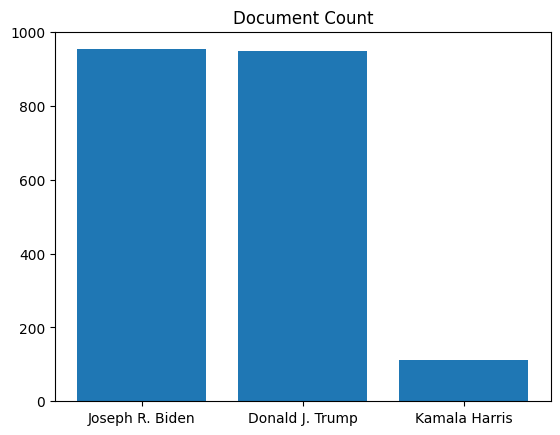

In [12]:
document_count = data_analysis['person'].value_counts()

plt.bar(x=document_count.index, height=document_count.values)
plt.title('Document Count')
plt.show()

#### Tokenization and related analysis

In [14]:
data_analysis['tokenized'] = data_analysis['transcript'].map(lambda x: tokenize(x, lemmatized=False, remove_stopword=False, remove_punct=False))

In [14]:
candidate_tokens = data_analysis.groupby('person')['tokenized'].sum()

candidate_tokens['Donald J. Trump'] = remove_elements(candidate_tokens['Donald J. Trump'], ['trump', 'j.', 'donald', 'president', 'vice'])
candidate_tokens['Joseph R. Biden'] = remove_elements(candidate_tokens['Joseph R. Biden'], ['joseph', 'joe', 'r.', 'biden', 'president', 'vice'])
candidate_tokens['Kamala Harris'] = remove_elements(candidate_tokens['Kamala Harris'], ['kamala', 'harris', 'president', 'vice'])

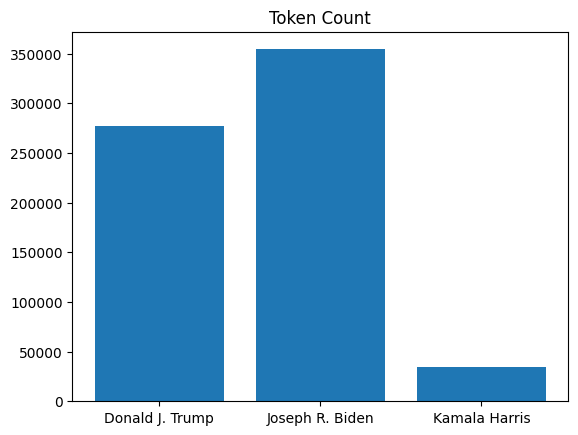

In [15]:
token_count = candidate_tokens.map(len)

plt.bar(x=token_count.index, height=token_count.values)
plt.title('Token Count')
plt.show()

In [16]:
candidate_vocab = candidate_tokens.map(create_vocab)

In [17]:
candidate_vocab

person
Donald J. Trump    {'repentance': 3, 'question': 172, 'major': 11...
Joseph R. Biden    {'major': 120, 'gajewski': 1, 'excite': 2, 'un...
Kamala Harris      {'launchpad': 1, 'question': 10, 'major': 17, ...
Name: tokenized, dtype: object

In [18]:
candidate_top_10_words = candidate_vocab.map(top_10_words)

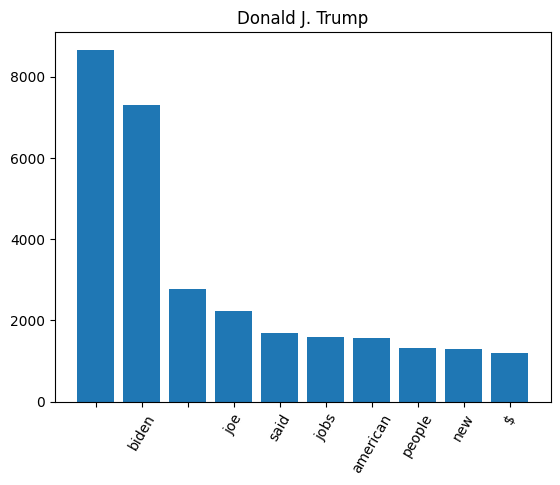

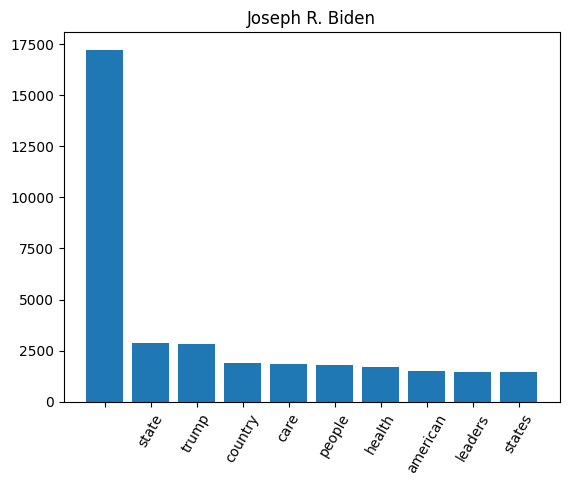

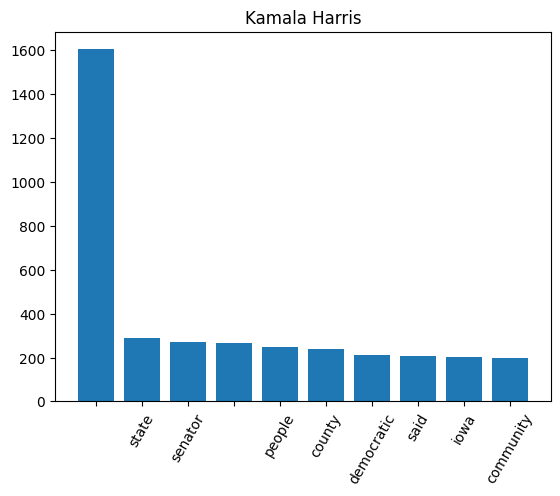

In [19]:
for candidate, top10 in candidate_top_10_words.items():
    plt.bar(x=top10.keys(), height=top10.values())
    plt.xticks(rotation=60)
    plt.title(candidate)
    plt.show()
#     print(candidate)

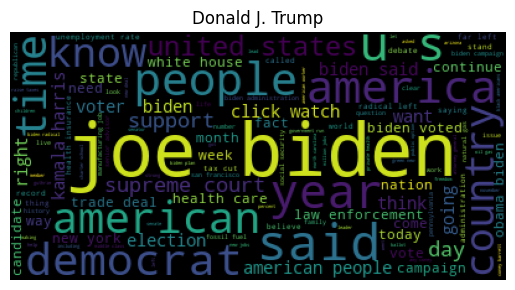

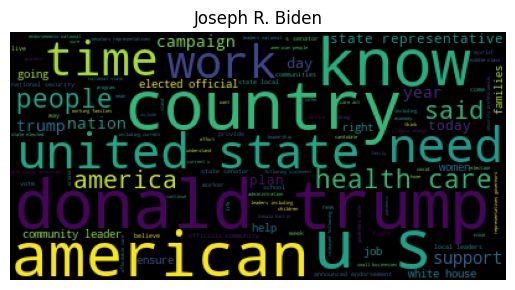

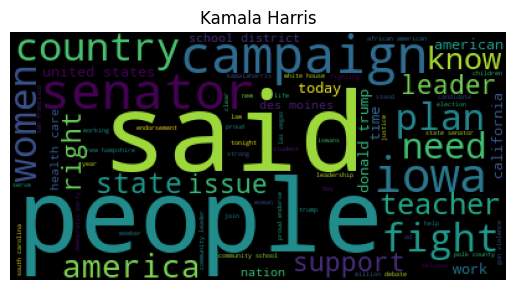

In [20]:
for index in candidate_tokens.index:
    text = ' '.join(candidate_tokens[index])
    wc = WordCloud().generate(text)
    plt.imshow(wc)
    plt.title(index)
    plt.axis('off')
    plt.show()

### Feature Space Generation

In [21]:
candidate_doc_tokens = data_analysis.groupby('person')['tokenized'].agg(list)

for index in candidate_doc_tokens.index:
    candidate_doc_tokens[index] = [" ".join(tokens) for tokens in candidate_doc_tokens[index]]

In [22]:
tfidf_vectorizer = TfidfVectorizer()
feature_space = tfidf_vectorizer.fit_transform(candidate_doc_tokens[0])
dense_feature_space = feature_space.toarray()
all_words = tfidf_vectorizer.get_feature_names_out().tolist()
df_tfidf = pd.DataFrame(dense_feature_space, columns=all_words)
total_tfidf_scores = df_tfidf.sum()
top_words = total_tfidf_scores.nlargest(10)
for word, tfidf_score in top_words.items():
    print(f"{word}: {tfidf_score}")

biden: 85.29937653333779
trump: 71.13371640109621
president: 62.67782768052567
joe: 34.96380417966379
jobs: 29.991073233205423
american: 27.7991539284866
campaign: 24.02735085928182
americans: 23.09942982787261
said: 23.02045999021821
economy: 20.277656518309087


In [23]:
tfidf_vectorizer = TfidfVectorizer()
feature_space = tfidf_vectorizer.fit_transform(candidate_doc_tokens[1])
dense_feature_space = feature_space.toarray()
all_words = tfidf_vectorizer.get_feature_names_out().tolist()
df_tfidf = pd.DataFrame(dense_feature_space, columns=all_words)
total_tfidf_scores = df_tfidf.sum()
top_words = total_tfidf_scores.nlargest(10)
for word, tfidf_score in top_words.items():
    print(f"{word}: {tfidf_score}")

biden: 84.11852449143977
president: 61.6293665447358
joe: 58.09918969221192
state: 47.61965965076396
trump: 40.11618833175633
leaders: 29.316205562390557
country: 25.812521567081184
people: 24.74025408269575
care: 23.377254041095345
health: 21.9835304425479


In [24]:
tfidf_vectorizer = TfidfVectorizer()
feature_space = tfidf_vectorizer.fit_transform(candidate_doc_tokens[2])
dense_feature_space = feature_space.toarray()
all_words = tfidf_vectorizer.get_feature_names_out().tolist()
df_tfidf = pd.DataFrame(dense_feature_space, columns=all_words)
total_tfidf_scores = df_tfidf.sum()
top_words = total_tfidf_scores.nlargest(10)
for word, tfidf_score in top_words.items():
    print(f"{word}: {tfidf_score}")

harris: 12.324778044262873
kamala: 7.37353717790865
iowa: 5.759175410551677
state: 5.125917644349874
president: 4.893506622137397
campaign: 4.307620955087182
senator: 4.215799249326183
democratic: 3.8202612939550344
people: 3.766284889996234
county: 3.7505919092926288


### Overall Sentiment (using TextBlob)

In [25]:
data_analysis['sentiment'] = data_analysis['transcript'].map(analyze_sentiment)

In [26]:
candidate_sentiment = data_analysis.groupby('person')['sentiment'].mean()

In [27]:
candidate_sentiment

person
Donald J. Trump    0.059404
Joseph R. Biden    0.120622
Kamala Harris      0.174205
Name: sentiment, dtype: float64

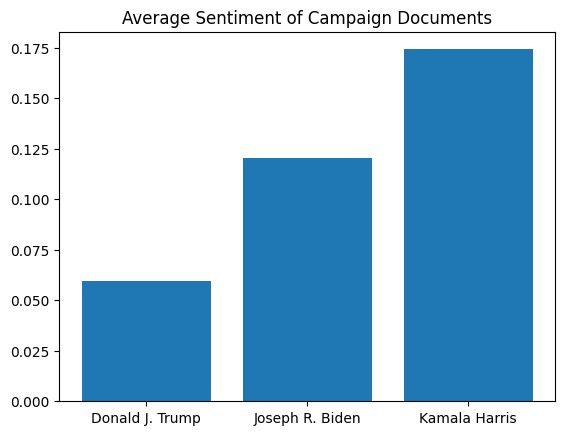

In [28]:
plt.bar(x=candidate_sentiment.index, height=candidate_sentiment.values)
plt.title('Average Sentiment of Campaign Documents')
plt.show()

In [29]:
data_analysis

,title,date,person,link,transcript,tokenized,sentiment
0,Biden Campaign Press Release - Biden for Presi...,2019-12-31T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-biden-...,\nCampaign Continues Growing Super Tuesday Inf...,"[campaign, continues, growing, super, tuesday,...",0.219434
1,Trump Campaign Statement - Happy New Year from...,2019-12-31T00:00:00+00:00,Donald J. Trump,/documents/trump-campaign-statement-happy-new-...,"\nAs we ring in a New Year, Brad Parscale, Cam...","[ring, new, year, brad, parscale, campaign, ma...",0.488799
2,Trump Campaign Statement - Merry Christmas fro...,2019-12-25T00:00:00+00:00,Donald J. Trump,/documents/trump-campaign-statement-merry-chri...,"\nIn celebration of Christmas Day, Lara Trump,...","[celebration, christmas, day, lara, trump, sen...",0.355000
3,Biden Campaign Press Release - California Cong...,2019-12-23T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-califo...,\nCárdenas becomes fifth Congressional Hispani...,"[cárdenas, fifth, congressional, hispanic, cau...",0.137754
4,Biden Campaign Press Release - Linn County Sup...,2019-12-23T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-linn-c...,"\nDes Moines, Iowa — Today, Brent Oleson — a L...","[des, moines, iowa, today, brent, oleson, linn...",0.154808
...,...,...,...,...,...,...,...
2007,Biden Campaign Press Release - South Carolina ...,2020-01-06T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-south-...,"\nCharleston, South Carolina — Today, South Ca...","[charleston, south, carolina, today, south, ca...",0.154630
2008,Biden Campaign Press Release - Biden for Presi...,2020-01-06T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-biden-...,\nCampaign Continues Growing Super Tuesday Inf...,"[campaign, continues, growing, super, tuesday,...",0.244654
2009,Biden Campaign Press Release - Reps. Elaine Lu...,2020-01-05T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-reps-e...,\nAll Three Members Represent Key Battleground...,"[members, represent, key, battleground, distri...",0.145555
2010,Biden Campaign Press Release - Rev. Rob Johnso...,2020-01-05T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-rev-ro...,\nVice President Biden Worshipped at Corinthia...,"[vice, president, biden, worshipped, corinthia...",0.132031


In [30]:
from nltk.sentiment import SentimentIntensityAnalyzer

# nltk.download('vader_lexicon')

In [31]:
# def vader_analyize_sentiment(text):
#     sid = SentimentIntensityAnalyzer()
#     sentiment_scores = sid.polarity_scores(text)
    
#     if sentiment_scores['compound'] >= 0.05:
#         return 'Positive'
#     elif sentiment_scores['compound'] <= -0.05:
#         return 'Negative'
#     else:
#         return 'Neutral'

In [32]:
df = data_analysis.drop(columns='sentiment')

In [33]:
df

,title,date,person,link,transcript,tokenized
0,Biden Campaign Press Release - Biden for Presi...,2019-12-31T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-biden-...,\nCampaign Continues Growing Super Tuesday Inf...,"[campaign, continues, growing, super, tuesday,..."
1,Trump Campaign Statement - Happy New Year from...,2019-12-31T00:00:00+00:00,Donald J. Trump,/documents/trump-campaign-statement-happy-new-...,"\nAs we ring in a New Year, Brad Parscale, Cam...","[ring, new, year, brad, parscale, campaign, ma..."
2,Trump Campaign Statement - Merry Christmas fro...,2019-12-25T00:00:00+00:00,Donald J. Trump,/documents/trump-campaign-statement-merry-chri...,"\nIn celebration of Christmas Day, Lara Trump,...","[celebration, christmas, day, lara, trump, sen..."
3,Biden Campaign Press Release - California Cong...,2019-12-23T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-califo...,\nCárdenas becomes fifth Congressional Hispani...,"[cárdenas, fifth, congressional, hispanic, cau..."
4,Biden Campaign Press Release - Linn County Sup...,2019-12-23T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-linn-c...,"\nDes Moines, Iowa — Today, Brent Oleson — a L...","[des, moines, iowa, today, brent, oleson, linn..."
...,...,...,...,...,...,...
2007,Biden Campaign Press Release - South Carolina ...,2020-01-06T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-south-...,"\nCharleston, South Carolina — Today, South Ca...","[charleston, south, carolina, today, south, ca..."
2008,Biden Campaign Press Release - Biden for Presi...,2020-01-06T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-biden-...,\nCampaign Continues Growing Super Tuesday Inf...,"[campaign, continues, growing, super, tuesday,..."
2009,Biden Campaign Press Release - Reps. Elaine Lu...,2020-01-05T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-reps-e...,\nAll Three Members Represent Key Battleground...,"[members, represent, key, battleground, distri..."
2010,Biden Campaign Press Release - Rev. Rob Johnso...,2020-01-05T00:00:00+00:00,Joseph R. Biden,/documents/biden-campaign-press-release-rev-ro...,\nVice President Biden Worshipped at Corinthia...,"[vice, president, biden, worshipped, corinthia..."


In [34]:
df['processed_transcript'] = df['tokenized'].map(lambda x: ' '.join(x))

In [35]:
sid = SentimentIntensityAnalyzer()
# Get sentiment scores for each transcript
df['compound_score'] = df['processed_transcript'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Classify sentiment based on the compound score
df['sentiment'] = df['compound_score'].apply(lambda x: 'Positive' if x >= 0.05 else 'Negative' if x <= -0.05 else 'Neutral')

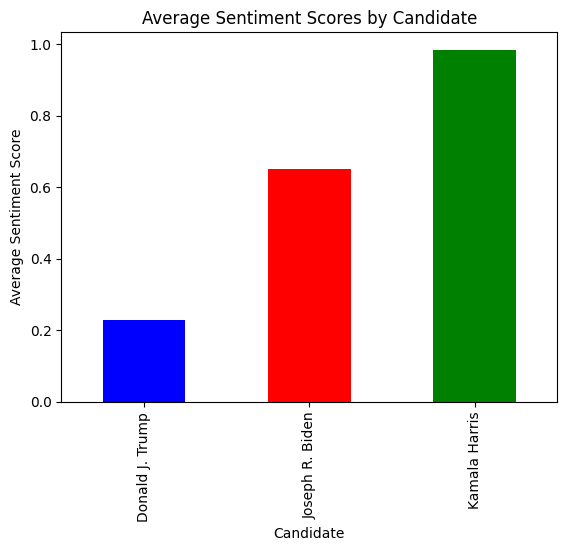

In [36]:
import matplotlib.pyplot as plt

# Group by candidate and calculate average sentiment scores
average_sentiment = df.groupby('person')['compound_score'].mean()

# Plot average sentiment scores for each candidate
average_sentiment.plot(kind='bar', color=['blue', 'red', 'green'])
plt.title('Average Sentiment Scores by Candidate')
plt.xlabel('Candidate')
plt.ylabel('Average Sentiment Score')
plt.show()

In [37]:
from nrclex import NRCLex

In [38]:
def nrc_raw_emotions(text):
    nrc = NRCLex(text)
    return nrc.raw_emotion_scores

In [39]:
emotion_df = pd.DataFrame(df['processed_transcript'])

In [ ]:
emotion_df.apply(lambda x: 

In [40]:
raw_emotions_df = emotion_df.apply(lambda x: nrc_raw_emotions(x['processed_transcript']), axis=1, result_type='expand')

In [41]:
raw_emotions_df

,positive,trust,anticipation,joy,negative,sadness,anger,fear,surprise,disgust
0,46.0,34.0,10.0,9.0,4.0,4.0,2.0,2.0,1.0,NaN
1,17.0,10.0,8.0,8.0,1.0,1.0,NaN,NaN,7.0,NaN
2,13.0,8.0,5.0,9.0,NaN,1.0,NaN,1.0,6.0,NaN
3,33.0,25.0,6.0,5.0,1.0,NaN,NaN,1.0,1.0,2.0
4,24.0,22.0,3.0,2.0,5.0,NaN,1.0,2.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2007,20.0,14.0,5.0,7.0,1.0,1.0,NaN,NaN,1.0,NaN
2008,39.0,22.0,10.0,6.0,3.0,2.0,NaN,NaN,7.0,2.0
2009,60.0,53.0,10.0,11.0,16.0,7.0,4.0,6.0,7.0,2.0
2010,35.0,30.0,13.0,12.0,9.0,5.0,5.0,8.0,3.0,2.0


In [42]:
emotions_df = pd.concat([emotion_df, raw_emotions_df], axis=1)

In [43]:
emotions_df.fillna(0, inplace=True)

In [44]:
emotions_df = pd.concat([emotions_df, df['person']], axis=1)

In [45]:
emotions_df

,processed_transcript,positive,trust,anticipation,joy,negative,sadness,anger,fear,surprise,disgust,person
0,campaign continues growing super tuesday infra...,46.0,34.0,10.0,9.0,4.0,4.0,2.0,2.0,1.0,0.0,Joseph R. Biden
1,ring new year brad parscale campaign manager d...,17.0,10.0,8.0,8.0,1.0,1.0,0.0,0.0,7.0,0.0,Donald J. Trump
2,celebration christmas day lara trump senior ad...,13.0,8.0,5.0,9.0,0.0,1.0,0.0,1.0,6.0,0.0,Donald J. Trump
3,cárdenas fifth congressional hispanic caucus m...,33.0,25.0,6.0,5.0,1.0,0.0,0.0,1.0,1.0,2.0,Joseph R. Biden
4,des moines iowa today brent oleson linn county...,24.0,22.0,3.0,2.0,5.0,0.0,1.0,2.0,2.0,0.0,Joseph R. Biden
...,...,...,...,...,...,...,...,...,...,...,...,...
2007,charleston south carolina today south carolina...,20.0,14.0,5.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,Joseph R. Biden
2008,campaign continues growing super tuesday infra...,39.0,22.0,10.0,6.0,3.0,2.0,0.0,0.0,7.0,2.0,Joseph R. Biden
2009,members represent key battleground districts v...,60.0,53.0,10.0,11.0,16.0,7.0,4.0,6.0,7.0,2.0,Joseph R. Biden
2010,vice president biden worshipped corinthian bap...,35.0,30.0,13.0,12.0,9.0,5.0,5.0,8.0,3.0,2.0,Joseph R. Biden


In [46]:
average_emotions = emotions_df.groupby('person')[['fear', 'anger', 'anticipation', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy']].mean()

In [47]:
average_emotions

,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy
person,,,,,,,,,,
Donald J. Trump,12.531151,9.178458,13.268215,28.974657,10.349525,36.068638,19.666315,9.923970,4.501584,9.232313
Joseph R. Biden,12.665268,9.976915,17.674711,37.801679,8.530955,52.682057,21.600210,10.563484,4.406086,12.612802
Kamala Harris,9.330357,8.428571,14.919643,35.401786,4.830357,46.428571,13.750000,5.776786,2.375000,11.071429


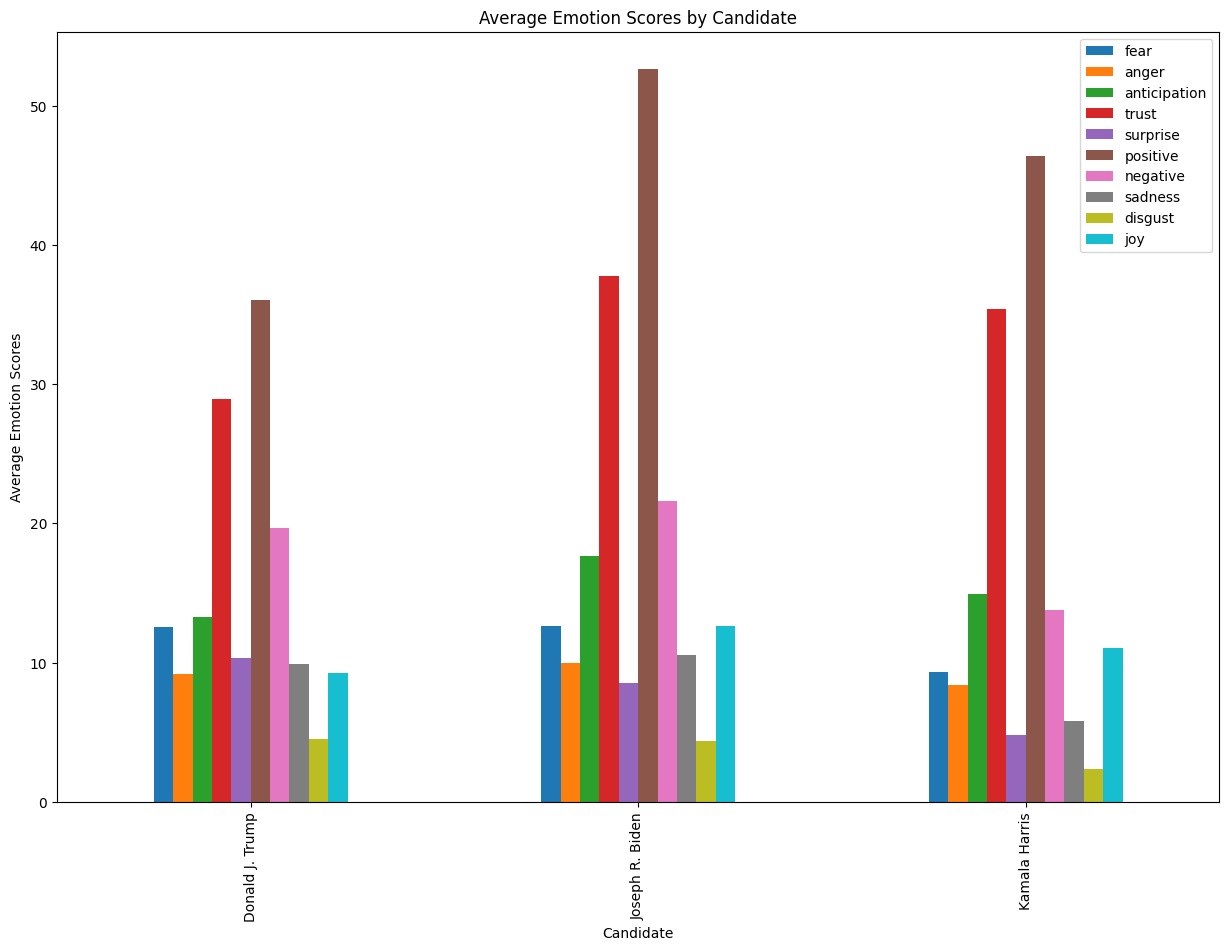

In [48]:
average_emotions.plot(kind='bar', figsize=(15, 10))
plt.title('Average Emotion Scores by Candidate')
plt.xlabel('Candidate')
plt.ylabel('Average Emotion Scores')
plt.show()

In [67]:
emotions_df.to_csv("emotion_df.csv",index = False)

In [50]:
temp_df = emotions_df.copy()

In [51]:
temp_df['outcome'] = 0

In [52]:
temp_df.loc[temp_df['person'] == 'Joseph R. Biden', 'outcome'] = 1

In [53]:
emotions_list = ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy']

In [54]:
corr = temp_df[emotions_list].corrwith(temp_df['outcome'])

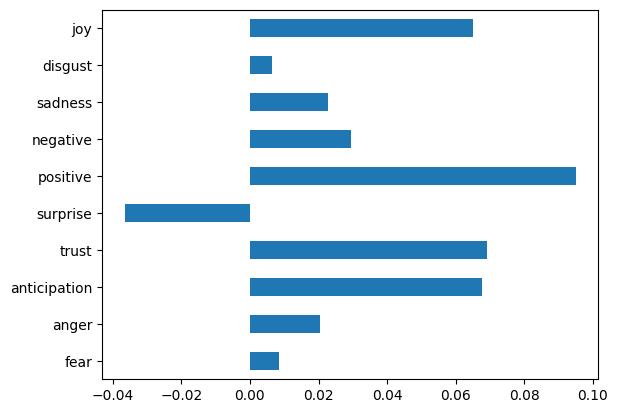

In [55]:
corr.plot.barh()
plt.show()

In [56]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyClassifier

In [64]:
temp_df = temp_df.drop(columns=['processed_transcript', 'person'])

KeyError: "['processed_transcript', 'person'] not found in axis"

In [58]:
X = temp_df.iloc[:, :-1]
y = temp_df.iloc[:, -1]

In [59]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [61]:
clf = LazyClassifier(verbose=1,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

  0%|                                                    | 0/29 [00:00<?, ?it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.7119205298013245, 'Balanced Accuracy': 0.7107471739729805, 'ROC AUC': 0.7107471739729805, 'F1 Score': 0.7120538367408079, 'Time taken': 0.06115293502807617}
{'Model': 'BaggingClassifier', 'Accuracy': 0.7864238410596026, 'Balanced Accuracy': 0.7827681279294183, 'ROC AUC': 0.7827681279294182, 'F1 Score': 0.7856923570339576, 'Time taken': 0.032755136489868164}
{'Model': 'BernoulliNB', 'Accuracy': 0.6009933774834437, 'Balanced Accuracy': 0.5856024262475875, 'ROC AUC': 0.5856024262475875, 'F1 Score': 0.5831203869962742, 'Time taken': 0.004286289215087891}


 31%|█████████████▋                              | 9/29 [00:00<00:00, 23.41it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.7218543046357616, 'Balanced Accuracy': 0.711353735869865, 'ROC AUC': 0.711353735869865, 'F1 Score': 0.7154263018854268, 'Time taken': 0.19014978408813477}
{'Model': 'CategoricalNB', 'Accuracy': 0.5529801324503312, 'Balanced Accuracy': 0.5214557485525227, 'ROC AUC': 0.5214557485525226, 'F1 Score': 0.45659639128389595, 'Time taken': 0.005203962326049805}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7450331125827815, 'Balanced Accuracy': 0.742531017369727, 'ROC AUC': 0.742531017369727, 'F1 Score': 0.7447287586304072, 'Time taken': 0.0072362422943115234}
{'Model': 'DummyClassifier', 'Accuracy': 0.5380794701986755, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.37648186827679125, 'Time taken': 0.00498199462890625}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.7235099337748344, 'Balanced Accuracy': 0.7205017921146953, 'ROC AUC': 0.7205017921146953, 'F1 Score': 0.7230304672540425, 'Time taken': 0.005240917205810547}
{'Model': 'E

 45%|███████████████████▎                       | 13/29 [00:00<00:00, 26.23it/s]

{'Model': 'LabelPropagation', 'Accuracy': 0.7599337748344371, 'Balanced Accuracy': 0.7563771712158809, 'ROC AUC': 0.7563771712158809, 'F1 Score': 0.7592212542172438, 'Time taken': 0.05706214904785156}
{'Model': 'LabelSpreading', 'Accuracy': 0.7599337748344371, 'Balanced Accuracy': 0.7558698649021229, 'ROC AUC': 0.7558698649021229, 'F1 Score': 0.7589963674827594, 'Time taken': 0.0522608757019043}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.7152317880794702, 'Balanced Accuracy': 0.7013950923628343, 'ROC AUC': 0.7013950923628344, 'F1 Score': 0.7039683679777425, 'Time taken': 0.14531707763671875}


 55%|███████████████████████▋                   | 16/29 [00:00<00:00, 16.13it/s]

{'Model': 'LinearSVC', 'Accuracy': 0.7251655629139073, 'Balanced Accuracy': 0.7149379652605459, 'ROC AUC': 0.7149379652605459, 'F1 Score': 0.719109862395769, 'Time taken': 0.1209261417388916}
{'Model': 'LogisticRegression', 'Accuracy': 0.7400662251655629, 'Balanced Accuracy': 0.7308133443617315, 'ROC AUC': 0.7308133443617314, 'F1 Score': 0.735265019200251, 'Time taken': 0.07651400566101074}
{'Model': 'NearestCentroid', 'Accuracy': 0.5960264900662252, 'Balanced Accuracy': 0.5751530190239867, 'ROC AUC': 0.5751530190239867, 'F1 Score': 0.561496481313531, 'Time taken': 0.029237985610961914}
{'Model': 'NuSVC', 'Accuracy': 0.7698675496688742, 'Balanced Accuracy': 0.7630714088778605, 'ROC AUC': 0.7630714088778605, 'F1 Score': 0.7673998297865074, 'Time taken': 0.0890359878540039}


 76%|████████████████████████████████▌          | 22/29 [00:01<00:00, 17.09it/s]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.5496688741721855, 'Balanced Accuracy': 0.5579487179487179, 'ROC AUC': 0.5579487179487179, 'F1 Score': 0.5454038113091847, 'Time taken': 0.011319160461425781}
{'Model': 'Perceptron', 'Accuracy': 0.6837748344370861, 'Balanced Accuracy': 0.6901736972704715, 'ROC AUC': 0.6901736972704715, 'F1 Score': 0.6827032670845455, 'Time taken': 0.019718170166015625}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.5298013245033113, 'Balanced Accuracy': 0.5526771436448855, 'ROC AUC': 0.5526771436448856, 'F1 Score': 0.4862836416372055, 'Time taken': 0.012905120849609375}
{'Model': 'RandomForestClassifier', 'Accuracy': 0.7996688741721855, 'Balanced Accuracy': 0.7986269644334161, 'ROC AUC': 0.7986269644334161, 'F1 Score': 0.7996937229161241, 'Time taken': 0.15754127502441406}
{'Model': 'RidgeClassifier', 'Accuracy': 0.7185430463576159, 'Balanced Accuracy': 0.7049793217535153, 'ROC AUC': 0.7049793217535153, 'F1 Score': 0.7078136088172535, 'Tim

 86%|█████████████████████████████████████      | 25/29 [00:01<00:00, 18.88it/s]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.7185430463576159, 'Balanced Accuracy': 0.7042183622828784, 'ROC AUC': 0.7042183622828783, 'F1 Score': 0.7065801016030925, 'Time taken': 0.08888387680053711}
{'Model': 'SGDClassifier', 'Accuracy': 0.7533112582781457, 'Balanced Accuracy': 0.7514915908464295, 'ROC AUC': 0.7514915908464295, 'F1 Score': 0.7532111982777784, 'Time taken': 0.023396968841552734}
{'Model': 'SVC', 'Accuracy': 0.7433774834437086, 'Balanced Accuracy': 0.7341439205955336, 'ROC AUC': 0.7341439205955335, 'F1 Score': 0.7386374393378273, 'Time taken': 0.07256197929382324}


 97%|█████████████████████████████████████████▌ | 28/29 [00:01<00:00, 16.08it/s]

{'Model': 'XGBClassifier', 'Accuracy': 0.7880794701986755, 'Balanced Accuracy': 0.7881113868210643, 'ROC AUC': 0.7881113868210643, 'F1 Score': 0.7882893386810933, 'Time taken': 0.13392400741577148}
[LightGBM] [Info] Number of positive: 674, number of negative: 734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478693 -> initscore=-0.085279
[LightGBM] [Info] Start training from score -0.085279


100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 14.94it/s]

{'Model': 'LGBMClassifier', 'Accuracy': 0.7831125827814569, 'Balanced Accuracy': 0.7819740832644059, 'ROC AUC': 0.7819740832644059, 'F1 Score': 0.7831394851405973, 'Time taken': 0.35764598846435547}
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score   
Model                                                                           
ExtraTreesClassifier               0.81               0.81     0.81      0.81  \
RandomForestClassifier             0.80               0.80     0.80      0.80   
XGBClassifier                      0.79               0.79     0.79      0.79   
BaggingClassifier                  0.79               0.78     0.78      0.79   
LGBMClassifier                     0.78               0.78     0.78      0.78   
NuSVC                              0.77               0.76     0.76      0.77   
LabelPropagation                   0.76               0.76     0.76      0.76   
LabelSpreading                     0.76               0.76     0.76     

In [62]:
from sklearn import metrics

In [63]:
print(metrics.classification_report(y_test, y_pred))

NameError: name 'y_pred' is not defined

In [ ]:
from scipy.stats import pearsonr

# Example: Calculate Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(temp_df[['anticipation', 'fear']], temp_df['outcome'])

print(f"Pearson Correlation Coefficient: {correlation_coefficient:.2f}")
print(f"P-value: {p_value:.4f}")

In [66]:
temp_df.to_csv("processed_temp.csv",index=False)